In [28]:
%matplotlib notebook
import math
from collections import Counter
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyximport
from dtaidistance import dtw
from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist, squareform
from sklearn import manifold
from sklearn.preprocessing import minmax_scale

pyximport.install()
from frechet import frechet
plt.rcParams['figure.figsize'] = [10, 8]

In [29]:
social = [('Adolescent fertility rate (births per 1,000 women ages 15-19)', 0.3),
          ('Net official development assistance and official aid received (current US$)', 0.1),
          ('Mortality rate, infant (per 1,000 live births)', 0.33),
          ('Mortality rate, under-5 (per 1,000 live births)', 0.18),
          ('Rural population (% of total population)', 0.09)
          ]
social_name = 'social_'
economy = [('International migrant stock, total', 0.02),
           ('Merchandise exports (current US$)', 0.08),
           ('Merchandise imports (current US$)', 0.08),
           ('GDP (current US$)', 0.12),
           ('GDP per capita (current US$)', 0.12),
           ('GNI (current US$)', 0.07),
           ('Exports of goods and services (% of GDP)', 0.06),
           ('External balance on goods and services (% of GDP)', 0.05),
           ('Imports of goods and services (% of GDP)', 0.06),
           ('Trade (% of GDP)', 0.2),
           ('Exports of goods and services (current US$)', 0.04),
           ('Imports of goods and services (current US$)', 0.04),
           ('Inflation, consumer prices (annual %)', 0.06),
           ]
economy_name = 'economy_'


In [30]:
base_name = economy_name
indicator_name = economy

In [31]:
df = pd.read_csv('WDI_csv/WDIData.csv',index_col='Country Name')
df = df.iloc[:, :-1]
print(df.shape)

(422400, 61)


In [32]:
def get_most_common_n(n):
    a = df[df['1960'].notnull()]['Indicator Name']
    test = Counter()
    for b, c in zip(a, a.index):
        test[b] += 1
    return test.most_common(n)

In [54]:
from scipy.interpolate import interp1d, CubicSpline, PchipInterpolator
from scipy.optimize import curve_fit
import math
import copy

def func_linear(x, a, b):
    return a + b * x

def func_cubic(x, a, b, c, d):
    return a + b * x + c * x**2 + d * x**3


def get_interpoled_data(datas):
    datas_copy = copy.deepcopy(datas)
    for i in range(datas.shape[0]):
    # for i in range(0, 1):
        original_row = datas.iloc[i:i+1,:]
        curated_row = original_row.dropna(axis='columns', how='any')
        
        if len(curated_row.values[0]) == 0:
            continue
            
        original_row = original_row.iloc[0]
        curated_row = curated_row.iloc[0]
        
        indexes = original_row.index.values
        indexes = indexes.astype(np.float)
    
        x = curated_row.index.values
        x = x.astype(np.float)
        y = curated_row.values
        
#         f = interp1d(x, y, kind='linear', fill_value='extrapolate')
#         cubicspline = CubicSpline(x, y, extrapolate='None')
#         Pchip = PchipInterpolator(x, y, extrapolate='True')
        
#         z = np.polyfit(x, y, 4)
#         p = np.poly1d(z)
        
        popt_linear, _ = curve_fit(func_linear, x, y)
#         popt_cubic, _ = curve_fit(func_cubic, x, y)
        
        flag = False
        for n in range(len(indexes)):
            if math.isnan(datas_copy.iat[i,n]):
                value = func_linear(indexes[n], *popt_linear)
                if(value < 0):
#                     print(value)
                    value = 0
                datas_copy.iat[i,n] = value
                flag = True
        if flag:
#             print(datas_copy.iloc[i:i+1,:].values)
            pass
    return datas_copy


def distance_matrix(X, f='correlation'):
    return pdist(X, metric=f)


def get_data_by_name(name, name_list):
    data = df[df['Indicator Name'] == name]
    data = data.iloc[:, 3:]
    data = get_interpoled_data(data)
    return data, data.index


def pretty_plot(ds, datas, tmp, name):
    t0 = time()
    mds = manifold.TSNE(2, random_state=0, metric='precomputed')
    Y = mds.fit_transform(ds)
    t1 = time()
    color = [tmp[i] for i in range(len(Y))]
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("TSNE (%.2g sec) %s" % ((t1 - t0), name))
    for i, txt in enumerate(datas):
        plt.annotate(txt, (Y[i, 0], Y[i, 1]))
#     plt.savefig(base_name + name + ".png", dpi = 500, bbox_inches='tight')
    plt.show()

In [55]:
# xnew = np.linspace(1960, 2017, endpoint=True)
# plt.plot(x, y, 'o', xnew, p(xnew), '-', xnew, cubicspline(xnew), '--', xnew, Pchip(xnew), '-', 
#          xnew, func_linear(xnew, *popt_linear), 'r-', xnew, func_cubic(xnew, *popt_cubic), 'b-')
# plt.legend(['data', 'polyfit interpolation', 'cubicspline interpolation', 'Pchip interpolation',
#             'linear function approximate', 'cubic function approximate'], loc='best')
# plt.show()

In [56]:
in_list = []
name_list = set(df.index)
for name, scale in indicator_name:
    try:
        frame, names = get_data_by_name(name, name_list)
        in_list.append((frame, scale))
        name_list &= set(names)
    except ValueError:
        print(name)
        continue

/usr/lib64/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [57]:
len(name_list)

264

In [58]:
import scipy
def calculate(out_list, method):
    print(scipy.special.binom(out_list[0][0].shape[0], 2))
    result = np.zeros(shape=(int(scipy.special.binom((out_list[0][0].shape[0]), 2),)))
    for X, scale in out_list:
        result += scale * distance_matrix(X, f=method)
    return result


In [59]:
out_list = []
name_list = sorted(list(name_list))

for pool, scale in in_list:
#     test_pool df.fillna(0, inplace=True)
    out_list.append((minmax_scale(pool.loc[name_list].fillna(0, inplace=False).values, axis=0), scale))
# print(out_list)
np.random.seed(3345)
scales = np.random.rand(len(out_list))

In [60]:
result_dtw = calculate(out_list, dtw.distance_fast)
result_frechet = calculate(out_list, frechet)
result_corr = calculate(out_list, 'correlation')


34716.0
34716.0
34716.0


<IPython.core.display.Javascript object>


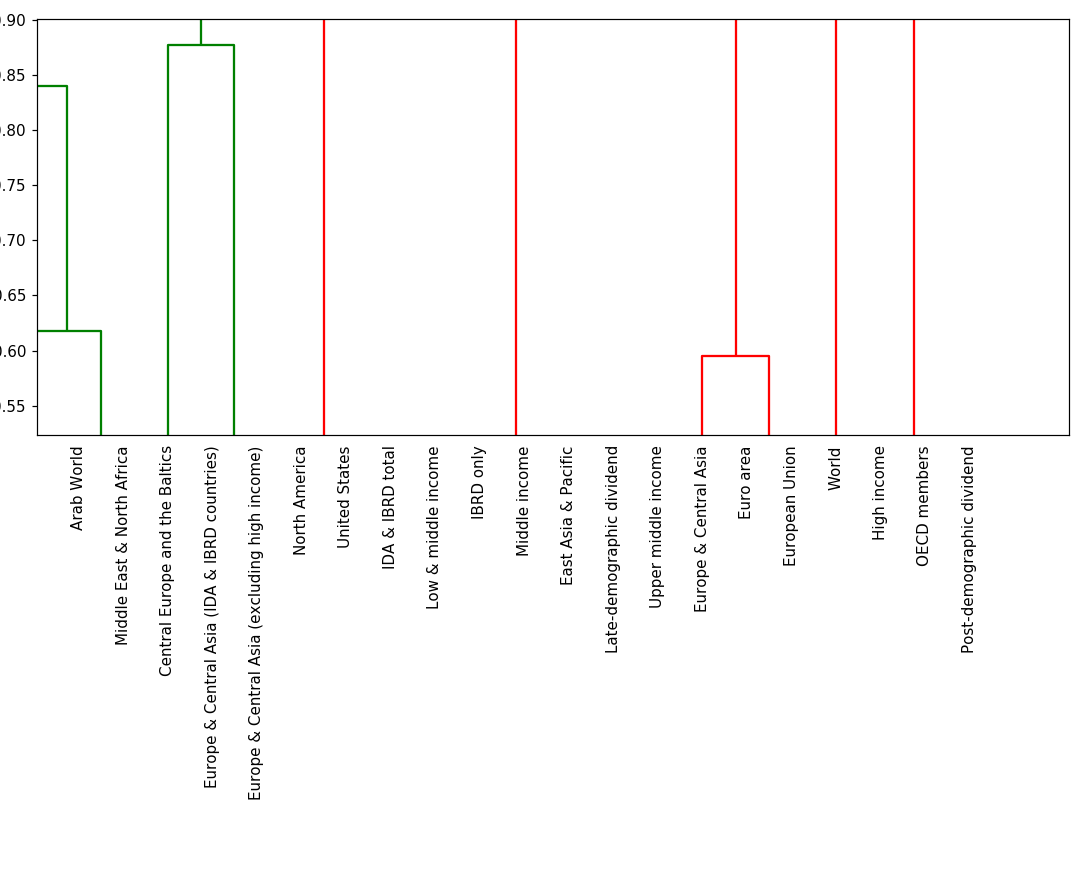

In [68]:

dist = ward(result_dtw)
dendrogram(dist, labels=name_list, leaf_font_size=10)
plt.tight_layout()
# plt.savefig(base_name + "result_dtw.png", dpi = 500, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


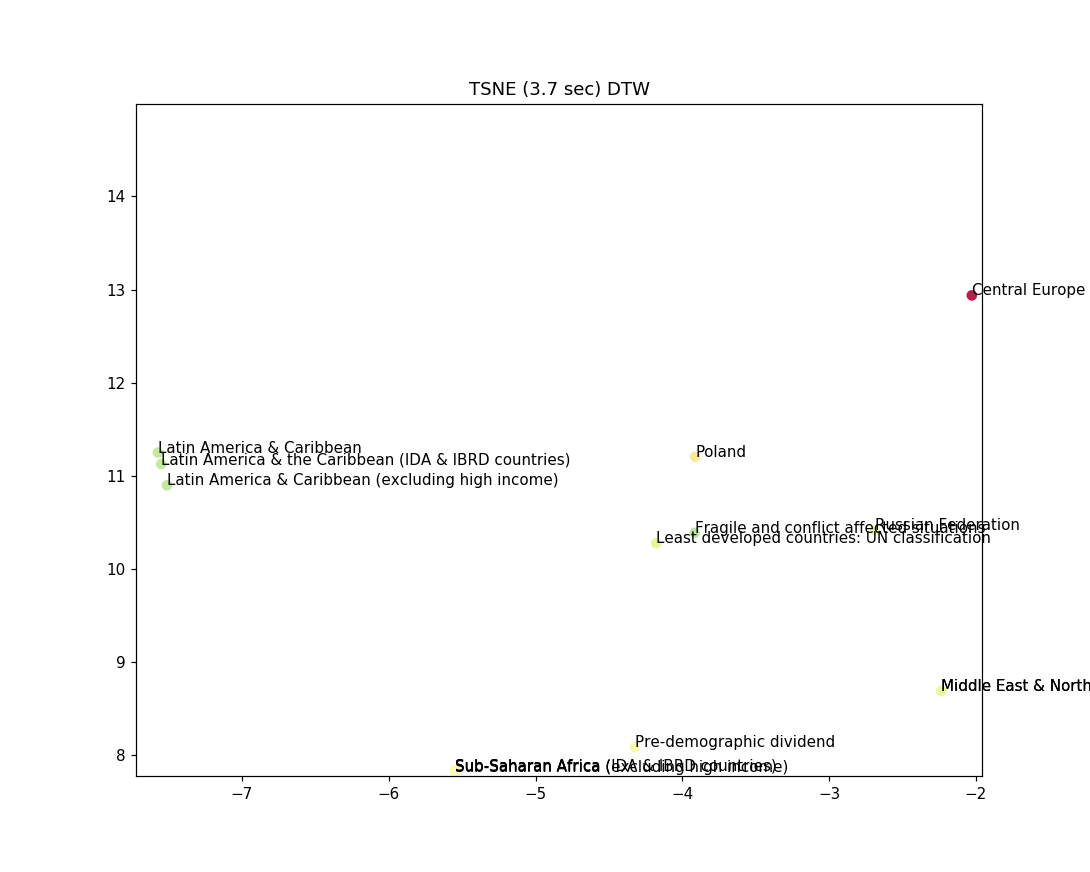

In [64]:
tmp = fcluster(dist, t=0.4)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(tmp))]
pretty_plot(squareform(result_dtw), name_list, [colors[i] for i in tmp], 'DTW')

<IPython.core.display.Javascript object>


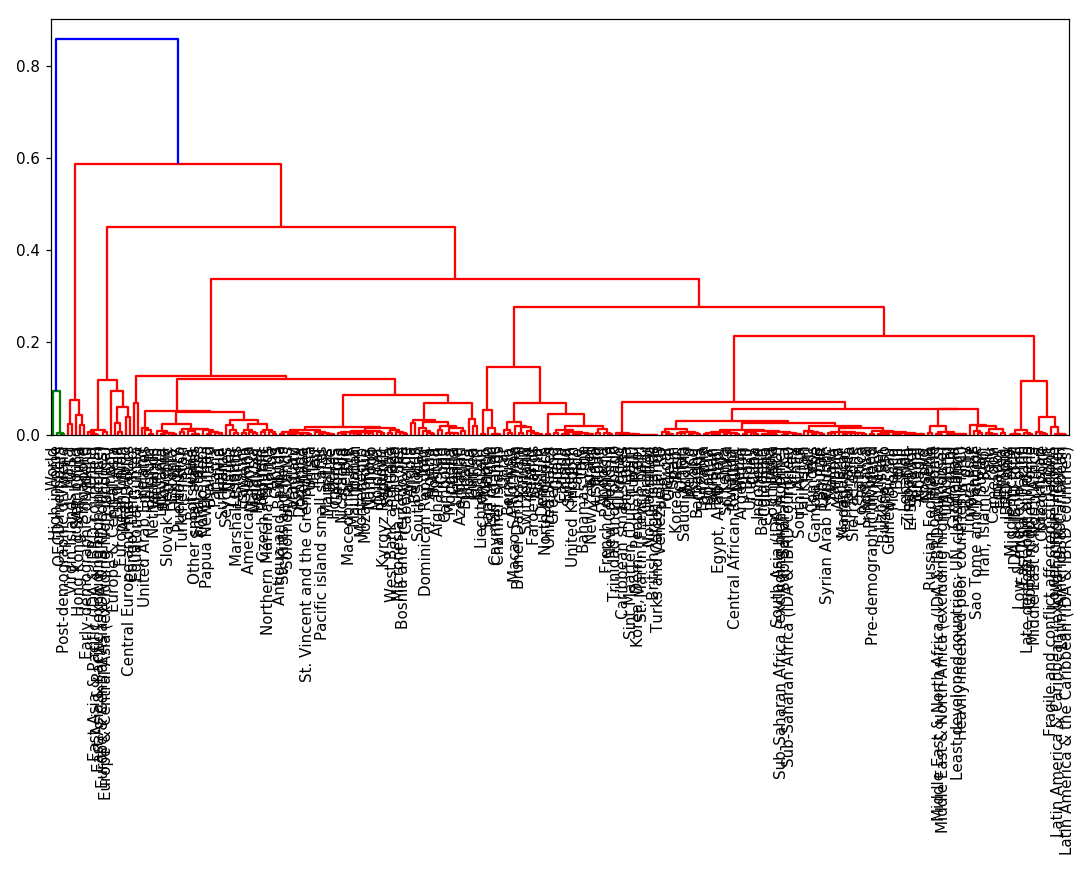

In [63]:
dist = ward(result_frechet)
dendrogram(dist, labels=name_list, leaf_font_size=10)
plt.tight_layout()
# plt.savefig(base_name + "result_frechet.png", dpi = 500, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


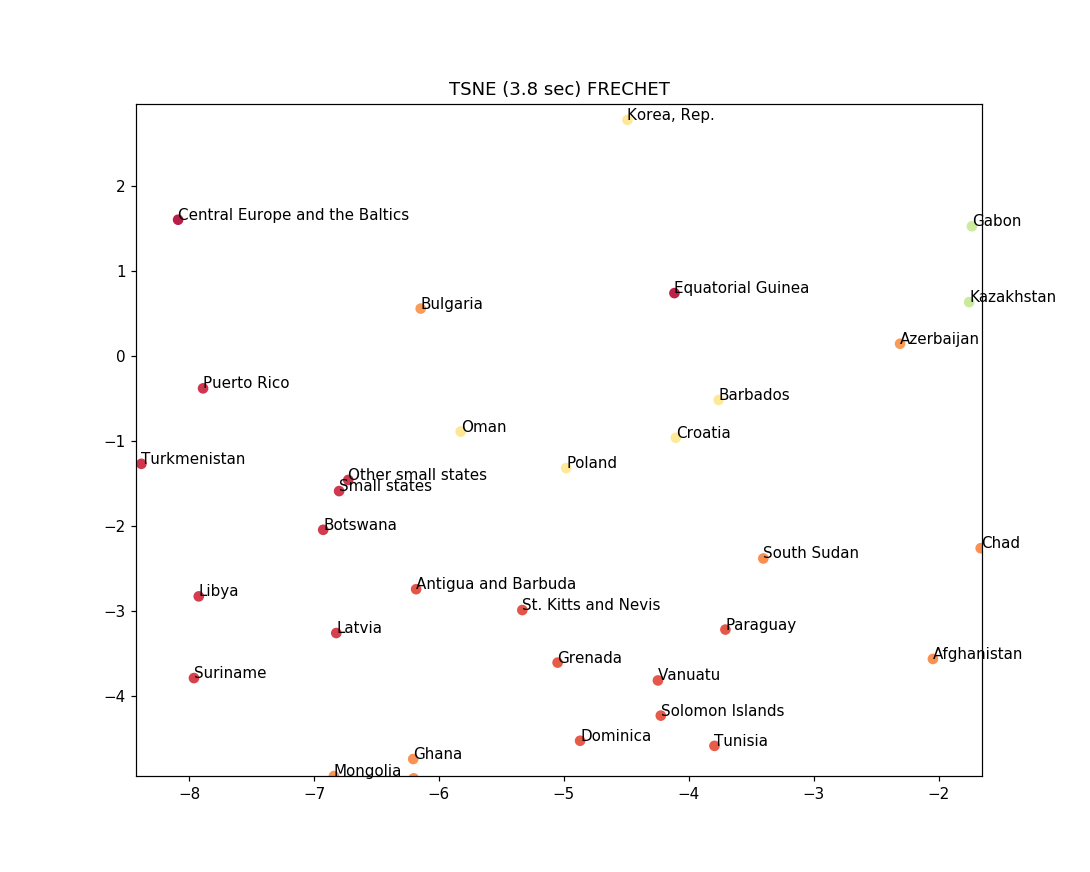

In [65]:
tmp = fcluster(dist, t=0.4)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(tmp))]
pretty_plot(squareform(result_frechet), name_list, [colors[i] for i in tmp], 'FRECHET')

<IPython.core.display.Javascript object>


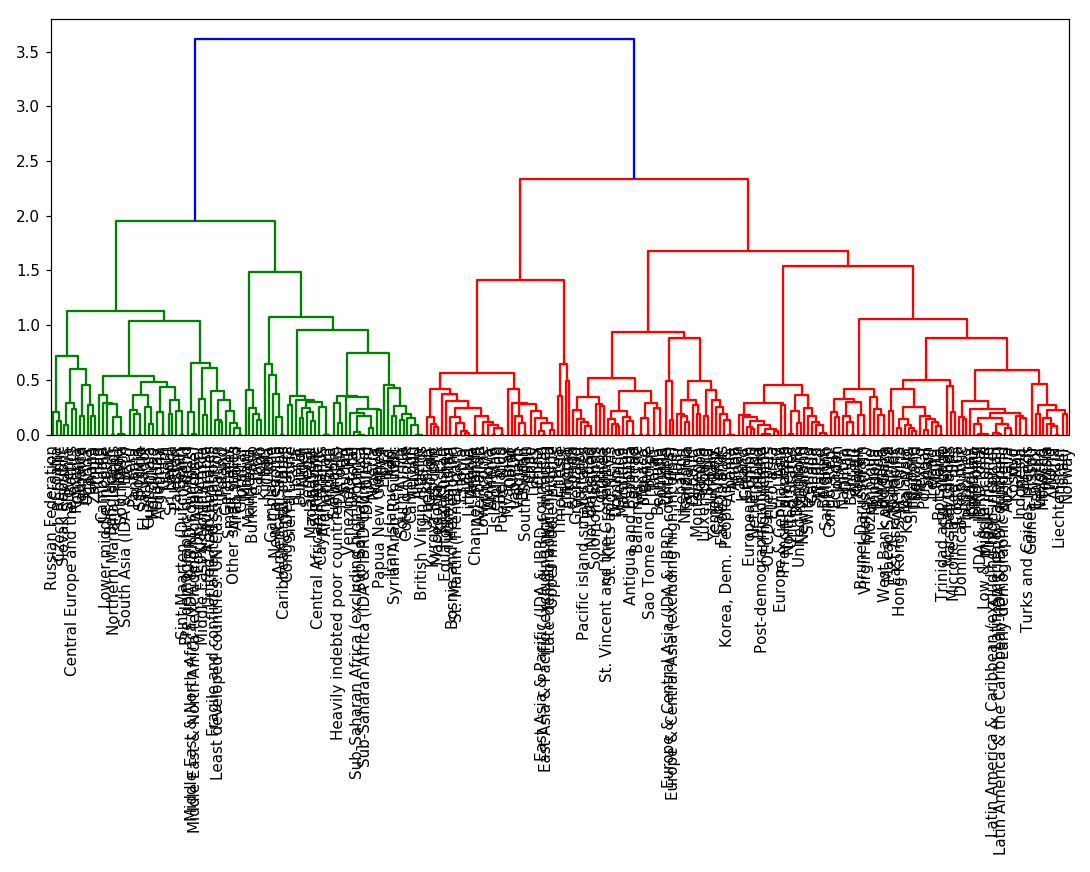

In [66]:
result_corr[np.isinf(result_corr)] = 0
np.nan_to_num(result_corr, False)
dist = ward(result_corr)
dendrogram(dist, labels=name_list, leaf_font_size=10)
plt.tight_layout()
# plt.savefig(base_name + "result_corr.png", dpi = 500, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


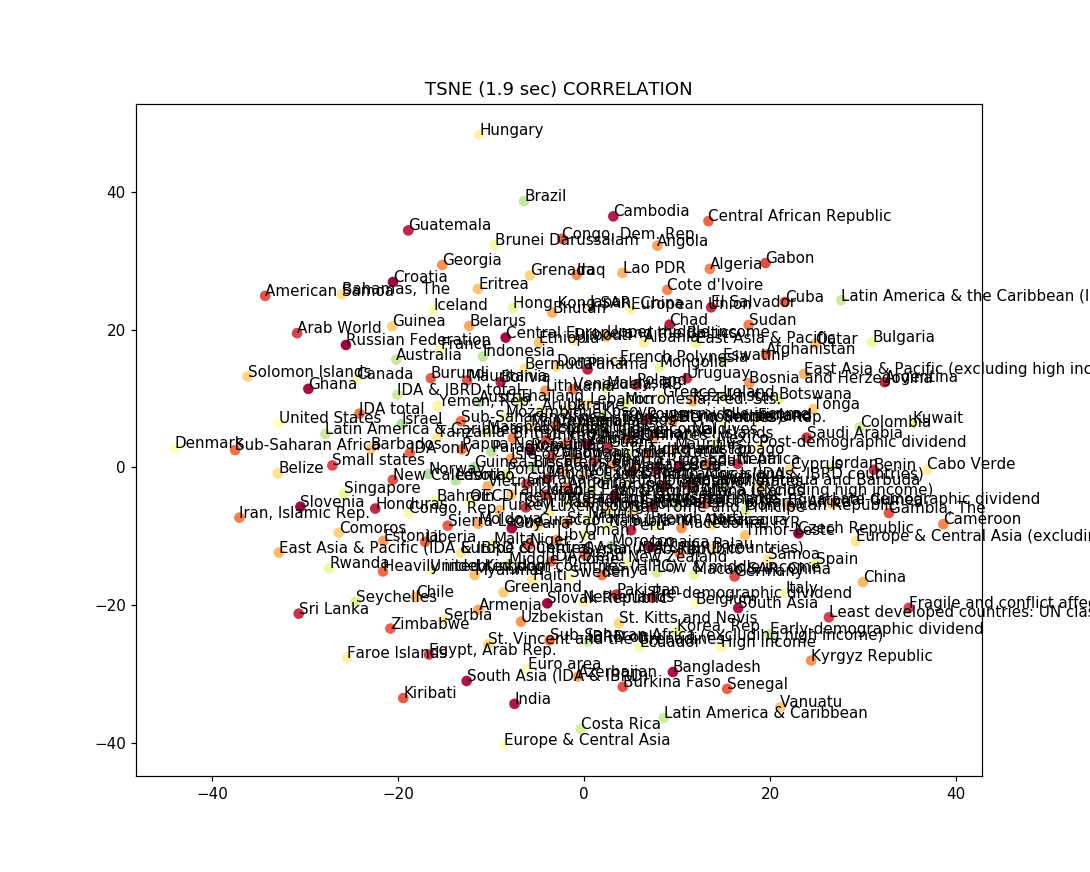

In [67]:
tmp = fcluster(dist, t=0.4)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(tmp))]
pretty_plot(squareform(result_corr), name_list, [colors[i] for i in tmp], 'CORRELATION')